In [2]:
import pandas as pd
import networkx as nx
import datetime
import seaborn as sns
from scipy import stats
import numpy as np
from pulp import *
from networkx.algorithms.approximation import vertex_cover
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, GammaRegressor
from sklearn.metrics import r2_score
import random
from sklearn import tree, svm, neighbors
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 
import statistics

#### 0. Data 

Imports data from csv's and performs necessary transformations 

##### 0.1 Import data:

In [3]:
#import contact tracing data
usersRaw = pd.read_csv("archive/users.csv")
users = pd.read_csv("archive/users.csv")
contacts = pd.read_csv("archive/contacts.csv")
print(len(users), len(contacts))

10000 2119889


#### Only run the next cell if you want to sample down the data (recommended if the cells generating nx.draw() graphs will be run)

In [345]:
#datasets are large and therefore make nx functions take a very long time, so let's sample the users to 0.5% of their current length:

users=(usersRaw[usersRaw['infected']=='yes'].sample(30)) #ensure some of the sample have positive diagnosis 
users=users.append(usersRaw.sample(int(len(usersRaw)/50)))
contacts=contacts[contacts['reporting_user'].isin(users['user_id'])] #ensure samples have users in common
contacts=contacts[contacts['contact_user'].isin(users['user_id'])]
print(len(users), len(contacts))


230 1096


In [4]:
print(users.dtypes)
users.head(15)

user_id            int64
first_name        object
last_name         object
gender            object
date_of_birth     object
phone_number      object
infected          object
date_diagnosis    object
dtype: object


,user_id,first_name,last_name,gender,date_of_birth,phone_number,infected,date_diagnosis
0,0,John,Morris,male,1986-07-14,409.731.1633x778,no,NaN
1,1,Jim,Johnson,male,1970-05-28,104-592-8856,no,NaN
2,2,Joe,Huggins,male,1976-06-01,551-547-4553x106,no,NaN
3,3,James,Mcevoy,male,1951-04-27,001-707-295-6628x33643,no,NaN
4,4,Franklin,Lloyd,male,1975-10-21,001-448-982-2809x315,no,NaN
5,5,Tommy,Mata,male,1987-05-07,+1-666-078-2636,no,NaN
6,6,Matt,Strong,male,1969-09-14,613-510-8096,no,NaN
7,7,Henry,Finley,male,2011-03-13,+1-182-487-7119x570,no,NaN
8,8,Michael,Penn,male,1986-06-03,+1-944-755-5230,no,NaN
9,9,Tony,Dole,male,2001-07-23,576-033-9446x1368,no,NaN


In [5]:
#glimpse contacts data
print(contacts.dtypes)
contacts.head(10)

reporting_user     int64
contact_user       int64
contact_start     object
contact_end       object
dtype: object


,reporting_user,contact_user,contact_start,contact_end
0,1824,3629,2020-08-01 10:38:00,2020-08-01 11:13:00
1,1824,4104,2020-08-03 03:43:00,2020-08-03 04:28:00
2,1824,9844,2020-08-03 01:43:00,2020-08-03 02:24:00
3,1824,7691,2020-08-03 10:12:00,2020-08-03 10:20:00
4,1824,2039,2020-08-01 05:51:00,2020-08-01 06:36:00
5,1824,1724,2020-08-01 07:40:00,2020-08-01 08:07:00
6,1824,895,2020-08-03 02:29:00,2020-08-03 02:44:00
7,409,8821,2020-08-02 08:09:00,2020-08-02 08:14:00
8,409,5152,2020-08-01 01:33:00,2020-08-01 01:55:00
9,409,8842,2020-08-01 22:39:00,2020-08-01 22:42:00


In [6]:
#if the whole dataset is used this takes a little while
#check that all reporting users are in users
for i in contacts["reporting_user"]:
    if (i in users["user_id"])==False:
        print("uh oh")
#check that all contact users are in users
for i in contacts["contact_user"]:
    if (i in users["user_id"])==False:
        print("uh oh")
#if nothing is printed we're good 

#### 0.2 Preprocessing:

In [7]:
#convert date columns to datetime, convert start and end  times of contact 
#to duration in seconds, reduce magnitude and invert 
#(so that smaller distance between nodes = closer contact between people)
users['date_diagnosis']=pd.to_datetime(pd.to_datetime(users['date_diagnosis']).dt.date) 
contacts['contact_start']=pd.to_datetime(contacts['contact_start'])
contacts['contact_end']=pd.to_datetime(contacts['contact_end'])
contacts['duration']=(contacts['contact_end']-contacts['contact_start'])
contacts['duration']=contacts['duration'].dt.seconds
contacts['duration']=100000/contacts['duration']
contacts=contacts.drop(columns=['contact_end'])
print(users.dtypes)
print(contacts.dtypes)

user_id                    int64
first_name                object
last_name                 object
gender                    object
date_of_birth             object
phone_number              object
infected                  object
date_diagnosis    datetime64[ns]
dtype: object
reporting_user             int64
contact_user               int64
contact_start     datetime64[ns]
duration                 float64
dtype: object


In [8]:
contacts=contacts.groupby(['reporting_user','contact_user']).first().reset_index()
contacts.head()

,reporting_user,contact_user,contact_start,duration
0,0,44,2020-08-09 22:48:00,333.333333
1,0,122,2020-08-08 17:45:00,119.047619
2,0,247,2020-08-18 11:57:00,37.037037
3,0,311,2020-08-06 07:04:00,75.757576
4,0,372,2020-08-17 17:03:00,83.333333


In [9]:
#Count number of infected users
print("Users with positive diagnosis:",len(users[users['infected']=='yes']))
print("Earliest diagnosis:",min(users[-np.isnat(users['date_diagnosis'])]['date_diagnosis'])) #earliest diagnosis
print("Latest diagnosis:",max(users[-np.isnat(users['date_diagnosis'])]['date_diagnosis'])) #latest diagnosis

Users with positive diagnosis: 500
Earliest diagnosis: 2020-08-01 00:00:00
Latest diagnosis: 2020-08-30 00:00:00


#### 1. Analysis

##### 1.0 Parameters :

In [10]:
# Select date to analyze:
dateOfInterest=datetime.datetime.strptime('2020-08-20 09:00:00','%Y-%m-%d %H:%M:%S') 

contacts.loc[contacts.contact_start > dateOfInterest,['contact_start']]=np.datetime64('NaT')
users.loc[users.date_diagnosis> dateOfInterest,['infected']]='no'
users.loc[users.date_diagnosis> dateOfInterest,['date_diagnosis']]=np.datetime64('NaT')


#Select how long a diagnosis is relevant (e.g. if thresholdTime = 14 days then for 14 days after diagnosis that person is considered contagious)
thresholdTime = datetime.timedelta(days=14)
#print(thresholdTime)

users

,user_id,first_name,last_name,gender,date_of_birth,phone_number,infected,date_diagnosis
0,0,John,Morris,male,1986-07-14,409.731.1633x778,no,NaT
1,1,Jim,Johnson,male,1970-05-28,104-592-8856,no,NaT
2,2,Joe,Huggins,male,1976-06-01,551-547-4553x106,no,NaT
3,3,James,Mcevoy,male,1951-04-27,001-707-295-6628x33643,no,NaT
4,4,Franklin,Lloyd,male,1975-10-21,001-448-982-2809x315,no,NaT
...,...,...,...,...,...,...,...,...
9995,9995,Hilda,Arguello,female,1947-10-22,+1-160-870-1139x879,no,NaT
9996,9996,Corrie,Vinson,female,1947-03-30,+1-592-124-8583x77023,no,NaT
9997,9997,Rebecca,Wells,female,1950-02-06,281.683.7930x7704,no,NaT
9998,9998,Lori,League,female,2018-01-08,001-593-656-4748x9486,no,NaT


In [11]:
#Count number of infected users
print("Users with positive diagnosis:",len(users[users['infected']=='yes']))
print("Earliest diagnosis:",min(users[-np.isnat(users['date_diagnosis'])]['date_diagnosis'])) #earliest diagnosis
print("Latest diagnosis:",max(users[-np.isnat(users['date_diagnosis'])]['date_diagnosis'])) #latest diagnosis

Users with positive diagnosis: 324
Earliest diagnosis: 2020-08-01 00:00:00
Latest diagnosis: 2020-08-20 00:00:00


#### 1.1 Graph Algorithms

This section takes in the imported and uses a graph structure to map those contacts. It uses the bellman-ford algorithm to compute the risk of contagion each user is at.

#### 1.1.0 Graph from dataset

In [22]:
G=nx.from_pandas_edgelist(contacts, "reporting_user", "contact_user", ["duration","contact_start"])
print(G)

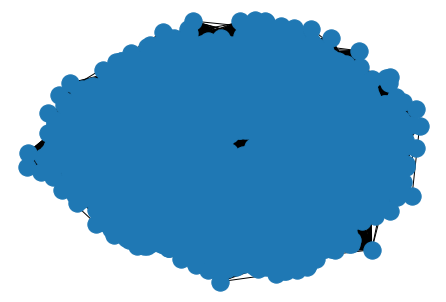

In [19]:
#if the whole dataset is used this takes a little while
nx.draw(G)

#### 1.1.1 Coloring nad adding data to nodes

In [23]:
#add details to nodes
for i in G.nodes:
    G.nodes[i]['color']='white'#make all nodes white
    G.nodes[i]['risk']='no_risk'
    G.nodes[i]['shortest_distance']=float('inf')
    G.nodes[i]['inverse_shortest_distance']=0
    G.nodes[i]['spread_potential']=0
    G.nodes[i]['diagnosis']='no'
    G.nodes[i]['diagnosis_date']=np.datetime64('NaT')
    G.nodes[i]['vaccinated']=False
    
#add demographics, diagnosis and date
k=0
for index, row in users.iterrows():
    if (row['infected']=='yes') and ((dateOfInterest-row['date_diagnosis']) <= thresholdTime): #make infected nodes black
        k+=1
        G.nodes[row['user_id']]['color']='black'
        G.nodes[row['user_id']]['diagnosis']='yes'
        G.nodes[row['user_id']]['diagnosis_date']=row['date_diagnosis']
        #print(G.nodes[row['user_id']])
        
print("There are this many black nodes: ", k)

There are this many black nodes:  226


In [24]:
#color at risk individuals gray
k = 0
w=0
for i in G.nodes: 
    if G.nodes[i]['color']=='black':
        for j in G.neighbors(i):
            if (G[i][j]['contact_start'] >= G.nodes[i]['diagnosis_date']) and (G[i][j]['contact_start']- G.nodes[i]['diagnosis_date'] <= datetime.timedelta(days=14)) and G.nodes[j]['color']!="gray":      
                G.nodes[j]['color']='gray' 
                k +=1 
print("There are this many gray nodes: ",k) 
print("There are this many white nodes: ",(len(usersRaw)-226-k))

There are this many gray nodes:  7183
There are this many white nodes:  2591


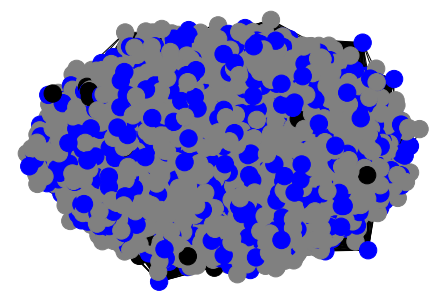

In [18]:
#visualize the colored nodes 
#if the whole dataset is used this takes a little while

color_map=[]
for i in G.nodes:
    if G.nodes[i]['color']=='white':
        color_map.append('blue') #making white nodes red so they are easier to see
    elif G.nodes[i]['color']=='black':
        color_map.append('black')
    elif G.nodes[i]['color']=='gray':
        color_map.append('gray')

        
nx.draw(G,node_color=color_map)


#### 1.1.1.0 Bellman_ford

In [25]:
#find the shortest path from each black node to the others
'''use bellman-ford to return the length of the shortest path between two nodes. 
   Length is weighted by the inverse of contact time, so someone who met with two 
    people who were exposed to the virus would have a shorter path through the 
    person who was exposed longer'''
bfdict = {}
for i in G.nodes:
    if G.nodes[i]['color']=='black':
        bfdict[i]=nx.single_source_bellman_ford_path_length(G,i,weight='duration')

In [26]:
shortestD = {}
for key in bfdict:
    for k in bfdict[key]:
        if (not(k in shortestD)) or (shortestD[k]>bfdict[key][k]):
            shortestD[k]=bfdict[key][k]      

In [27]:
#grab all smallest distances and make them a list to do some summary statistics
shortestL = list(shortestD.values())
quart = np.percentile(shortestL,[25,50,75])
print(quart)
statistics.mean(shortestL)


[30.16774892 33.33333333 42.73504274]


37.35050856175367

#### 1.1.2 Assigning Risk

In [28]:
#assigning risk
'''we'll keep it simple and assign risk by quartile: 
if your distance to the nearest infected person is 
<=1st percentile, we'll assign that user to high risk, if 
1st percentile < distance <= median, moderate risk, if 
median < distance <= 3rd percentile, low risk, and > 3rd p
would be no risk at the moment.'''
kno=0
klow=0
kmod=0
khigh=0


for i in G.nodes: 
    if i in shortestD:
        G.nodes[i]['shortest_distance']=shortestD[i]
        if shortestD[i]!=0:
            G.nodes[i]['inverse_shortest_distance']=(1/shortestD[i])
        else:
            G.nodes[i]['inverse_shortest_distance']=float('inf')
            kno+=1
        if shortestD[i] <= quart[0]:
            G.nodes[i]['risk']='high_risk'
            khigh+=1
        elif (shortestD[i] > quart[0]) and (shortestD[i] <= quart[1]):
            G.nodes[i]['risk']='moderate_risk'
            kmod+=1
        elif (shortestD[i] > quart[1]) and (shortestD[i] <= quart[2]):
            G.nodes[i]['risk']='low_risk'
            klow+=1
    if G.nodes[i]['color']=='black':
        G.nodes[i]['risk']='infected'
        
print(kno,klow,kmod,khigh)

100 2586 2517 2500


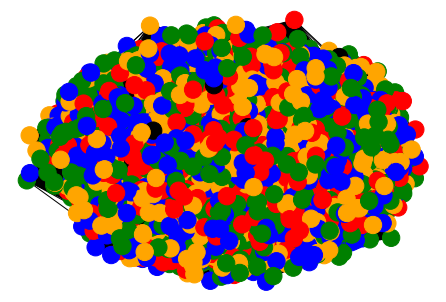

In [29]:
#redraw but with color = risk
color_map=[]
for i in G.nodes:
    if G.nodes[i]['risk']=='no_risk':
        color_map.append('green') 
    elif G.nodes[i]['risk']=='low_risk':
        color_map.append('blue')
    elif G.nodes[i]['risk']=='moderate_risk':
        color_map.append('orange')
    elif G.nodes[i]['risk']=='high_risk':
        color_map.append('red')
    elif G.nodes[i]['risk']=='infected':
        color_map.append('black')

nx.draw(G,node_color=color_map)

#### 1.1.3 Spread Potential

In [30]:
#add spread-potential: if a node has many neighbors that are at lower risk, 
#they have a greater potential for spreading the virus than someone with 
#less lower-risk neighbors. The spread potential value is the mmount of 
#neighbors at lower risk (higher minimum distance from sick person) a node has.

for i in G.nodes: 
    k = 0
    for j in G.neighbors(i):
        if G.nodes[i]['shortest_distance'] < G.nodes[j]['shortest_distance']:
            k +=1 
    G.nodes[i]['spread_potential']=k

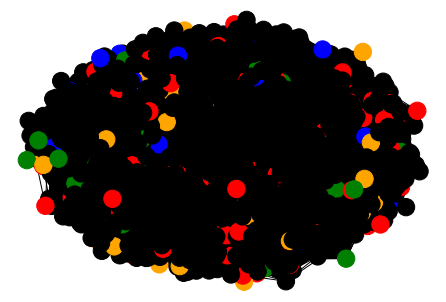

In [31]:
#redraw but with color = spread potential
color_map=[]

for i in G.nodes:
    if G.nodes[i]['spread_potential']>=16:
        color_map.append('black')
    elif G.nodes[i]['spread_potential']>=8:
        color_map.append('red')
    elif G.nodes[i]['spread_potential']>=4:
        color_map.append('orange')
    elif G.nodes[i]['spread_potential']>=2:
        color_map.append('blue')
    elif G.nodes[i]['spread_potential']>=0:
        color_map.append('green')

nx.draw(G,node_color=color_map)

In [32]:
#summary of graph:
Counter = 0
print(nx.info(G))
for i in G.nodes:
    if G.nodes[i]['color']=='gray':
        Counter +=1
Counter


Name: 
Type: Graph
Number of nodes: 10000
Number of edges: 2075407
Average degree: 415.0814


7183

In [33]:
#view resulting Graph: (uncomment next line)
G.nodes(data=True)

NodeDataView({0: {'color': 'gray', 'risk': 'moderate_risk', 'shortest_distance': 30.303030303030305, 'inverse_shortest_distance': 0.033, 'spread_potential': 235, 'diagnosis': 'no', 'diagnosis_date': numpy.datetime64('NaT'), 'vaccinated': False}, 44: {'color': 'gray', 'risk': 'low_risk', 'shortest_distance': 37.03703703703704, 'inverse_shortest_distance': 0.027, 'spread_potential': 158, 'diagnosis': 'no', 'diagnosis_date': numpy.datetime64('NaT'), 'vaccinated': False}, 122: {'color': 'white', 'risk': 'no_risk', 'shortest_distance': 56.98421975452952, 'inverse_shortest_distance': 0.017548717948717946, 'spread_potential': 16, 'diagnosis': 'no', 'diagnosis_date': numpy.datetime64('NaT'), 'vaccinated': False}, 247: {'color': 'gray', 'risk': 'high_risk', 'shortest_distance': 28.24858757062147, 'inverse_shortest_distance': 0.0354, 'spread_potential': 379, 'diagnosis': 'no', 'diagnosis_date': numpy.datetime64('NaT'), 'vaccinated': False}, 311: {'color': 'gray', 'risk': 'moderate_risk', 'shorte

#### 1.2 Integer Optimization:

If we only have a limited ammount of vaccines, whom do we prioritize?

#### 1.2.0 Parameters:

In [34]:
# input vaccines aavailable:
VaccineCount = 50

#### 1.2.1 Problem setup

In [35]:
#set up an optimization problem
#del(prob) #clear prob if already run
GVaccL=[]

#make a second graph with only users that haven't had a positive diagnosis
for i in G.nodes:
    if G.nodes[i]['diagnosis']=='no':
        GVaccL.append(i)

GVacc = G.subgraph(GVaccL)
#(GVacc.nodes(data=True))

def WhoToVaccinate(G,V):
    ''' Goal: Maximize the spread potential of nodes vaccinated. 
    Assume: if a node is vaccinated, they won't contract or spread 
    the dissease even if they are in prolonged high risk contact.
    Implied: there's no point in vaccinating people who already 
    have or had the disease'''
    prob = LpProblem(name="Vaccines", sense=LpMaximize)

   
    #decision variables:
    users = pulp.LpVariable.dicts('user',(name for name in G.nodes),
                                   lowBound=0,upBound=1,
                                   cat='Integer')
    #users
    spread=nx.get_node_attributes(G,'spread_potential')
    risk=nx.get_node_attributes(G,'inverse_shortest_distance')
    #add linear variables 
    prob += lpSum(users[i]*spread[i]*risk[i] for i in G.nodes)
    prob += lpSum(users[i] for i in G.nodes) <=V
    prob.solve()
    print(LpStatus[prob.status])
    Vaccinations = []
    print("Vaccinate: ")
    for i in users:
        if users[i].varValue > 0:
            Vaccinations.append(i)
            print(users[i])

    return (Vaccinations)

In [36]:
Vaccinations=WhoToVaccinate(GVacc,VaccineCount)


Optimal
Vaccinate: 
user_959
user_7159
user_8674
user_5452
user_4302
user_67
user_5646
user_9422
user_2164
user_7423
user_439
user_9312
user_3597
user_7491
user_4198
user_9090
user_16
user_2317
user_2694
user_3913
user_7558
user_9940
user_219
user_3612
user_1911
user_5277
user_4160
user_933
user_2591
user_3738
user_5252
user_6352
user_9512
user_879
user_3186
user_2681
user_1359
user_3376
user_1160
user_7699
user_2381
user_222
user_2375
user_6306
user_4938
user_7775
user_9999
user_7239
user_8533
user_3740


In [37]:
#Since vaccinating (presumably) makes a node innocuous to otehrs, 
#it is aking to fully isolating that node. So, when a node is 
#vaccinated we remove the edges that connect them to others.

def Vaccinate(G,V):
    '''Takes a graph, G, and a list of user indexes to vaccinate, V'''
    Edges=[]
    G2 = G.copy() #prevents altering the object we iterate over
    for i in V: 
        G2.nodes[i]['vaccinated']=True
        G2.nodes[i]['color']='white'
        G2.nodes[i]['spread_potential']=0
        G2.nodes[i]['risk']='no_risk'
        G2.nodes[i]['shortest_distance']=float('inf')
        G2.nodes[i]['inverse_shortest_distance']=0
        for j in G.edges(i):
            Edges.append([i,j])
        G2.remove_edges_from(G.edges(i))

    return G2
            

GVaccinated=Vaccinate(G,Vaccinations)
#GVaccinated.nodes(data=True)
#GVaccinated.edges
#G.nodes(data=True)

#### Linear Regression

In [54]:
%%capture
#What's the relationship between the number of vaccines
#we give out and the number of edges we drop? Is the 
#relationship linear? #Let's estimate a linear regression and check. 

#Geenrate data for regression (this takes a while if using the whole dataset)
EdgesLeft=[None]*10
VaccinesGiven=[None]*10

#Populate lists with some values 
#blockPrint()
for i in range(0,100,10):
    index=int(i/10)
    VaccinesGiven[index]=i
    Vac=WhoToVaccinate(GVacc,i)
    G3= Vaccinate(GVacc,Vac)
    EdgesLeft[index]=G3.number_of_edges()
    
#enablePrint()

In [55]:
print(EdgesLeft,VaccinesGiven)
EV=pd.DataFrame({"Edges":EdgesLeft,"Vaccines":VaccinesGiven})
EV

[1982973, 1977624, 1972514, 1967495, 1962539, 1957753, 1952969, 1948238, 1943440, 1938760] [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]


,Edges,Vaccines
0,1982973,0
1,1977624,10
2,1972514,20
3,1967495,30
4,1962539,40
5,1957753,50
6,1952969,60
7,1948238,70
8,1943440,80
9,1938760,90


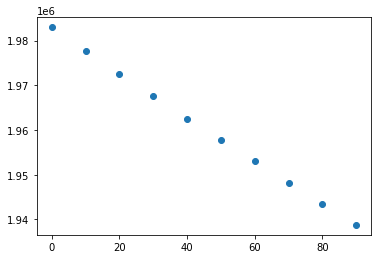

In [56]:
x=EV["Vaccines"]
y=EV["Edges"]
vaccines=np.array(x).reshape((-1,1)) # -1 means: numpy figure out number of rows!
edges=np.array(y).reshape((-1,1))

#plot
plt.scatter(vaccines,edges)

intercept: [1982438.2]
slope: [[-489.06]]


0.9996453937253797

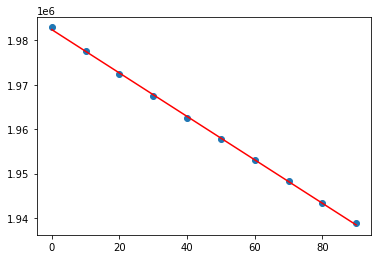

In [57]:
model = LinearRegression()
model.fit(vaccines,edges)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
edges_pred = model.predict(vaccines)
plt.scatter(x,y)
#plt.figure()
plt.plot(vaccines, edges_pred, color='red')
r2_score(edges,edges_pred) #0.9998844264869999, not bad

#note: if we try this with a smaller sample 
#than the whole dataset we can see that the 
#relationship is not fully linear, but the error is 
#normally distributed enough to still fit a linear 
#regression with R^2 of 0.93

#### Minimum Vertex Cover:

In [42]:
#What's the minimum maount of vaccines needed to stop spread altogether?
#We persume vaccinating the black nodes would achieve nothing since they 
#are already infected, but what is the minimum number of neighbors of 
#black nodes we should vaccinate to prevent spread?

#This is akin to the minimum vertex cover of the subgraph contianing only non-black nodes. 
GVaccL=[]

#make a second graph with only users that haven't had a positive diagnosis
for i in G.nodes:
    if G.nodes[i]['diagnosis']=='no':
        GVaccL.append(i)

GVacc = G.subgraph(GVaccL)
#print(GVacc.nodes(data=True))
print(nx.info(GVacc))
MWVC=nx.algorithms.approximation.vertex_cover.min_weighted_vertex_cover(GVacc,weight='duration')
len(MWVC)
#G.nodes(data=True)

Name: 
Type: Graph
Number of nodes: 9774
Number of edges: 1982973
Average degree: 405.7649


9756

#### Dynamic Programming:

In [43]:
# turn node information into a data frame for next sections
Nodes=usersRaw

for i in G.nodes:
    Nodes.loc[i,"Spread Potential"]=G.nodes[i]["spread_potential"]
    Nodes.loc[i,"Color"]=G.nodes[i]["color"]
    Nodes.loc[i,"Shortest Distance"]=G.nodes[i]["shortest_distance"]
    Nodes.loc[i,"Inverse Shortest Distance"]=G.nodes[i]["inverse_shortest_distance"]
    Nodes.loc[i,"Edges"]=len(G.edges(Nodes.loc[i,"user_id"]))

Nodes=Nodes.drop(["user_id","phone_number","first_name","date_diagnosis","last_name"],1)    
Nodes.columns=["Gender","Date of Birth","Diagnosis","Spread Potential","Color","Shortest Distance","Inverse Shortest Distance","Edges"]
#convert categorical variables to numeric
Nodes['Gender'].replace(to_replace ='female', value =0, inplace=True)
Nodes['Gender'].replace(to_replace ='male', value =1, inplace=True) 
Nodes['Diagnosis'].replace(to_replace ='no', value =0, inplace=True)
Nodes['Diagnosis'].replace(to_replace ='yes', value =1, inplace=True) 
Nodes['Color'].replace(to_replace='white',value=0,inplace=True)
Nodes['Color'].replace(to_replace='gray',value=1,inplace=True)
Nodes['Color'].replace(to_replace='black',value=2,inplace=True)
Nodes = Nodes.fillna(value=0)
Nodes["Age"]=(dateOfInterest-pd.to_datetime(Nodes["Date of Birth"],format="%Y-%m-%d")).astype('timedelta64[Y]')
#print(G.nodes(data=True))
Nodes

,Gender,Date of Birth,Diagnosis,Spread Potential,Color,Shortest Distance,Inverse Shortest Distance,Edges,Age
0,1,1986-07-14,0,235.0,1,30.303030,0.033000,354.0,34.0
1,1,1970-05-28,0,131.0,1,37.037037,0.027000,409.0,50.0
2,1,1976-06-01,0,41.0,1,53.763441,0.018600,314.0,44.0
3,1,1951-04-27,0,337.0,1,29.761905,0.033600,432.0,69.0
4,1,1975-10-21,0,13.0,1,56.984220,0.017549,413.0,44.0
...,...,...,...,...,...,...,...,...,...
9995,0,1947-10-22,0,247.0,1,33.333333,0.030000,445.0,72.0
9996,0,1947-03-30,0,21.0,0,56.984220,0.017549,413.0,73.0
9997,0,1950-02-06,0,130.0,1,37.878788,0.026400,419.0,70.0
9998,0,2018-01-08,0,379.0,1,28.735632,0.034800,460.0,2.0


In [44]:
# Say the nodes we identified forvaccination are not available / willing to innoculate, 
#and we want to find a subset of other nodes that add up to the same 
#spread potential*inverse shortest distance value
#We can use a dynamic programming miplementation of subset sum on our dataframe for this

def isSubsetSum(df_slice,sum):
    values=[]
    for i in df_slice:
        if i != float('inf'):
            values.append(int(i))
        else:
            values.append(1000) #replace inf with alrge numbers since int() can't convert inf
    n=len(values)
    print(n)
    subset =([[False for i in range(sum + 1)] for i in range(n + 1)]) 
    for i in range(n + 1): 
        subset[i][0] = True
        for i in range(1, sum + 1): 
            subset[0][i]= False
              
        for i in range(1, n + 1): 
            for j in range(1, sum + 1): 
                if j<values[i-1]: 
                    subset[i][j] = subset[i-1][j] 
                if j>= values[i-1]: 
                    subset[i][j] = (subset[i-1][j] or subset[i - 1][j-int(values[i-1])]) 
                    
    return subset[n][sum] 


In [45]:
Nodes=Nodes.sample(1000)
Nodes["Product"]=Nodes["Inverse Shortest Distance"]*Nodes["Spread Potential"]*100
ProductSS=isSubsetSum(Nodes["Product"],11)
EdgesSS=isSubsetSum(Nodes["Edges"],6)
print(ProductSS,EdgesSS)

1000
1000
True False


#### 2.6 Bonus: Showing that dataset is not a good fit for Machine Learning Classification of diagnosis based on demographics and contact patterns

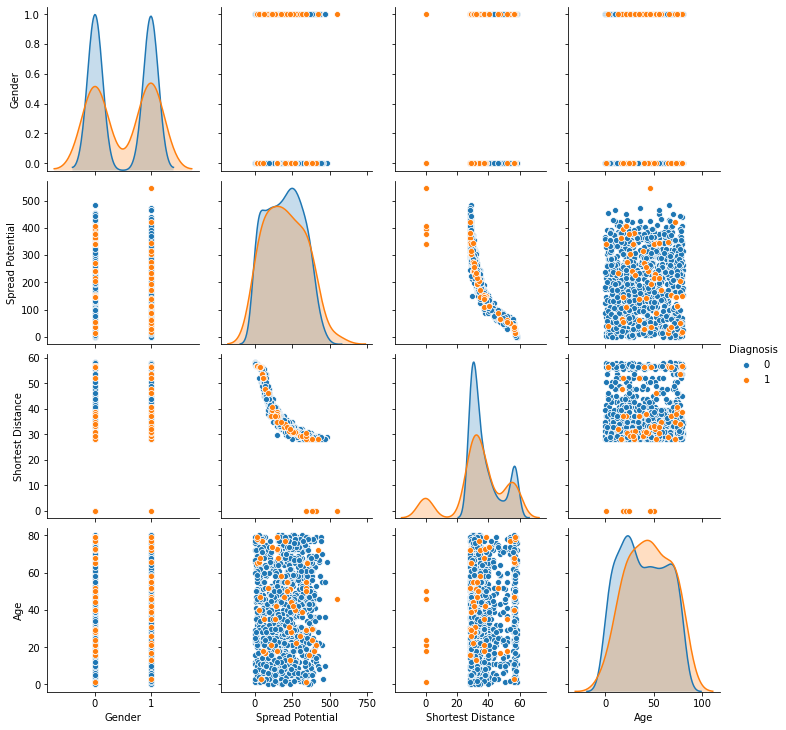

In [46]:
g=sns.pairplot(Nodes[["Gender","Diagnosis","Spread Potential","Shortest Distance","Age"]], hue='Diagnosis',diag_kind="auto") 